In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import random
import json
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import optuna

e:\Projects\Github\Predicting-Bitcoin-Returns-with-Long-Short-Term-Memory-LSTM-Neural-Networks\btc-pred\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    print("CUDA is available.")
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available.")

CUDA is available.
CUDA device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 2060


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Set seeds

In [4]:
seed_value = 52
torch.manual_seed(seed_value)

## Prepare Data 


Additionally, visualize the data

In [5]:
#Load in data
with open('config.json') as f:
    config = json.load(f)

data_path = config["bit-finex"]

df = pd.read_csv(data_path)

ts = df["close"].values

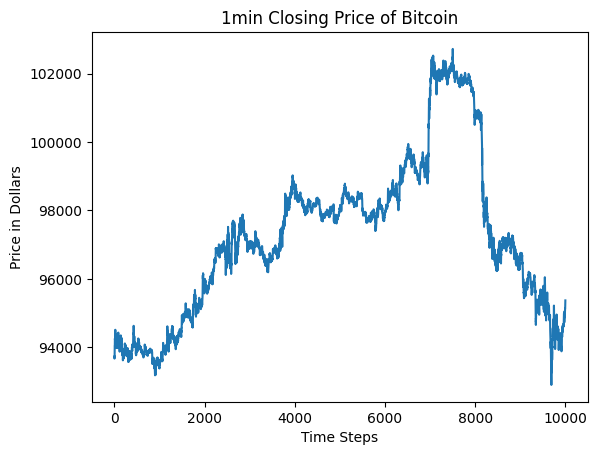

In [6]:
plt.plot(ts)
plt.title('1min Closing Price of Bitcoin')
plt.xlabel('Time Steps')
plt.ylabel('Price in Dollars')
plt.savefig('graphs/btc-price.png')
plt.show()

## Preprocessing Data

Check dimensions

In [7]:
print(ts.shape)
ts = ts.reshape(-1,1)
print(ts.shape)

(10000,)
(10000, 1)


Data conversion

In [8]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ts)

In [9]:
# train-test split for time series
train_size = int(len(scaled_data) * 0.70)
train, rest = scaled_data[:train_size], scaled_data[train_size:]
validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

print(len(train))
print(len(validation))
print(len(test))

7000
1500
1500


## Hyper Parameter Optimization

In [10]:
study = optuna.create_study(
    study_name="lstm-btc-1",
    storage="sqlite:///study.db",  # Save to SQLite file,
    direction='minimize',
    load_if_exists=True  # Load existing study if it exists
)

class LSTM(nn.Module):
    def __init__(self, hidden_size, num_layers,):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x

def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)


# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_size = trial.suggest_int("hidden_size", 100, 256)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    lookback = trial.suggest_int("lookback", 1, 30)

    # Prepare the dataset with the chosen lookback
    def create_dataset(data, lookback):
        X, y = [], []
        for i in range(len(data) - lookback):
            X.append(data[i:i + lookback])
            y.append(data[i + lookback])
        return np.array(X), np.array(y)

    X_train, y_train = create_dataset(train, lookback)
    X_valid, y_valid = create_dataset(validation, lookback)
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32).to(device)
    y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).to(device)

    # Initialize the model
    model = LSTM(hidden_size=hidden_size, num_layers=num_layers)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    train_loader = data.DataLoader(data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

    # Training loop
    n_epochs = 50
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation evaluation
        model.eval()
        with torch.no_grad():
            y_valid_pred = model(X_valid_tensor)
            valid_rmse = torch.sqrt(loss_fn(y_valid_tensor, y_valid_pred))

        trial.report(valid_rmse, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return valid_rmse

# Initialize Optuna study and optimize
study.optimize(objective, n_trials=100)
best_params = study.best_params

# Best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

[I 2025-01-09 20:43:41,965] A new study created in RDB with name: lstm-btc-1
[I 2025-01-09 20:44:28,827] Trial 0 finished with value: 0.031390782445669174 and parameters: {'hidden_size': 138, 'num_layers': 1, 'lookback': 26}. Best is trial 0 with value: 0.031390782445669174.
[I 2025-01-09 20:45:31,225] Trial 1 finished with value: 0.04013378545641899 and parameters: {'hidden_size': 233, 'num_layers': 2, 'lookback': 15}. Best is trial 0 with value: 0.031390782445669174.
[I 2025-01-09 20:46:56,326] Trial 2 finished with value: 0.043061595410108566 and parameters: {'hidden_size': 214, 'num_layers': 3, 'lookback': 18}. Best is trial 0 with value: 0.031390782445669174.
[I 2025-01-09 20:48:14,982] Trial 3 finished with value: 0.04725167527794838 and parameters: {'hidden_size': 203, 'num_layers': 3, 'lookback': 16}. Best is trial 0 with value: 0.031390782445669174.
[I 2025-01-09 20:48:50,702] Trial 4 finished with value: 0.033670976758003235 and parameters: {'hidden_size': 132, 'num_layers': 

Best hyperparameters: {'hidden_size': 138, 'num_layers': 1, 'lookback': 26}
Best validation RMSE: 0.031390782445669174


### Create tensor dataset

In [11]:
lookback = best_params['lookback']
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_valid, y_valid = create_dataset(validation, lookback=lookback)

Convert to tensors

In [12]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).to(device)

Inspect shape of tensors

In [13]:
print(f"X_train, y_train shape {X_train_tensor.shape, y_train_tensor.shape}")
print(f"X_valid, y_valid shape: {X_valid_tensor.shape, y_valid_tensor.shape}")
print(f"X_test, y_test shape: {X_test_tensor.shape, y_test_tensor.shape}")

X_train, y_train shape (torch.Size([6974, 26, 1]), torch.Size([6974, 1]))
X_valid, y_valid shape: (torch.Size([1474, 26, 1]), torch.Size([1474, 1]))
X_test, y_test shape: (torch.Size([1474, 26, 1]), torch.Size([1474, 1]))


## Training


In [14]:
model = LSTM(hidden_size=best_params['hidden_size'], num_layers=best_params['num_layers'])
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train_tensor, y_train_tensor), shuffle=True, batch_size=32)

n_epochs = 150

# Loss tracking
train_losses = []
valid_losses = []
eval_epoch = []

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #Progress Printer
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train_tensor)
            train_rmse = torch.sqrt(loss_fn(y_pred, y_train_tensor))
            
            y_pred = model(X_valid_tensor)
            valid_rmse = torch.sqrt(loss_fn(y_pred, y_valid_tensor))

            train_losses.append(train_rmse.item())
            valid_losses.append(valid_rmse.item())
            eval_epoch.append(epoch)
        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, validation RMSE {valid_rmse:.4f}")


Epoch 0: train RMSE 0.0415, validation RMSE 0.0688
Epoch 10: train RMSE 0.0264, validation RMSE 0.0461
Epoch 20: train RMSE 0.0261, validation RMSE 0.0741
Epoch 30: train RMSE 0.0199, validation RMSE 0.0298
Epoch 40: train RMSE 0.0204, validation RMSE 0.0302
Epoch 50: train RMSE 0.0201, validation RMSE 0.0401
Epoch 60: train RMSE 0.0202, validation RMSE 0.0306
Epoch 70: train RMSE 0.0205, validation RMSE 0.0326
Epoch 80: train RMSE 0.0202, validation RMSE 0.0303
Epoch 90: train RMSE 0.0203, validation RMSE 0.0301
Epoch 100: train RMSE 0.0203, validation RMSE 0.0386
Epoch 110: train RMSE 0.0199, validation RMSE 0.0382
Epoch 120: train RMSE 0.0205, validation RMSE 0.0390
Epoch 130: train RMSE 0.0197, validation RMSE 0.0332
Epoch 140: train RMSE 0.0196, validation RMSE 0.0339


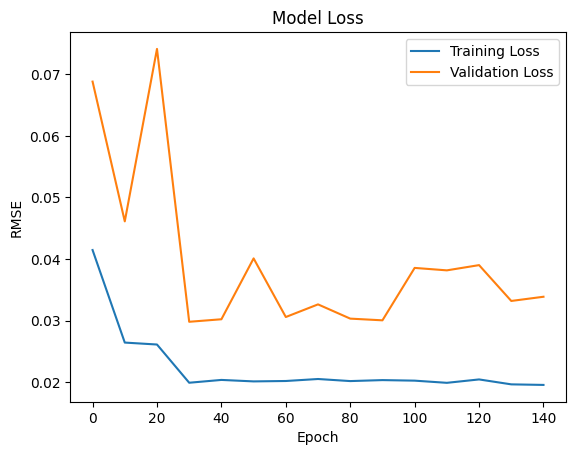

In [15]:
plt.plot(eval_epoch, train_losses, label="Training Loss")
plt.plot(eval_epoch, valid_losses, label="Validation Loss")
plt.title('Model Loss')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('graphs/train-validation-loss-lstm.png')
plt.show()

## Plotting Results of LSTM



train RMSE 44.9164, validation RMSE 71.2778, test RMSE 73.0711


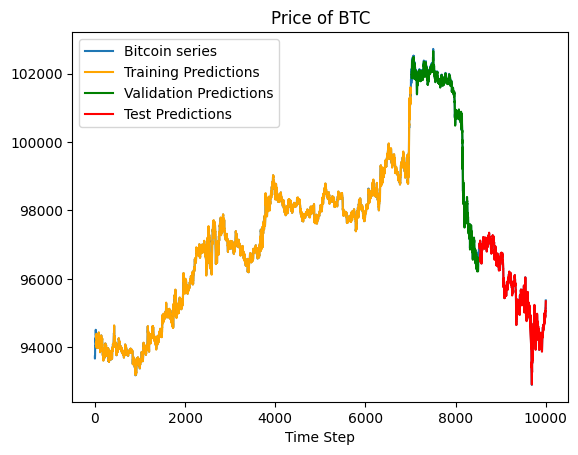

In [16]:
with torch.no_grad():
    #Make predictions
    train_pred = model(X_train_tensor).cpu()
    valid_pred = model(X_valid_tensor).cpu()
    test_pred = model(X_test_tensor).cpu()

# Convert prediction tensor objects to np arrays
train_pred = train_pred.detach().numpy()
valid_pred = valid_pred.detach().numpy()
test_pred = test_pred.detach().numpy()

# Reshape np arrays
train_pred = train_pred.reshape(-1,1)
valid_pred = valid_pred.reshape(-1,1)
test_pred = test_pred.reshape(-1,1)

y_train = y_train.reshape(-1,1)
y_valid = y_valid.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Convert data and predictions to original scale
original_train_pred = scaler.inverse_transform(train_pred)
original_valid_pred = scaler.inverse_transform(valid_pred)
original_test_pred = scaler.inverse_transform(test_pred)

original_y_train = scaler.inverse_transform(y_train)
original_y_valid = scaler.inverse_transform(y_valid)
original_y_test = scaler.inverse_transform(y_test)

#Reshape
original_train_pred = original_train_pred.reshape(-1,1)
original_valid_pred = original_valid_pred.reshape(-1,1)
original_test_pred = original_test_pred.reshape(-1,1)

# Calculate Loss
rmse_train = np.sqrt(mean_squared_error(original_train_pred, original_y_train))
rmse_valid = np.sqrt(mean_squared_error(original_valid_pred, original_y_valid))
rmse_test = np.sqrt(mean_squared_error(original_test_pred, original_y_test))
print(f"train RMSE {rmse_train:.4f}, validation RMSE {rmse_valid:.4f}, test RMSE {rmse_test:.4f}")

# Initialize plots with NaN values
train_plot = np.full_like(ts, np.nan, dtype=float)
valid_plot = np.full_like(ts, np.nan, dtype=float)
test_plot = np.full_like(ts, np.nan, dtype=float)

# Place predictions in their respective plots 
train_plot[lookback:train_size] = original_train_pred
valid_plot[train_size+lookback:train_size+len(y_valid)+lookback] = original_valid_pred
test_plot[train_size+lookback+len(y_valid)+lookback:] = original_test_pred

# plot
plt.plot(ts, label='Bitcoin series')
plt.plot(train_plot, c='orange', label="Training Predictions")
plt.plot(valid_plot, c='green', label='Validation Predictions')
plt.plot(test_plot, c='r', label='Test Predictions')
plt.xlabel('Time Step')
plt.title('Price of BTC')
plt.legend()
plt.savefig('graphs/overall-results-lstm.png')
plt.show()

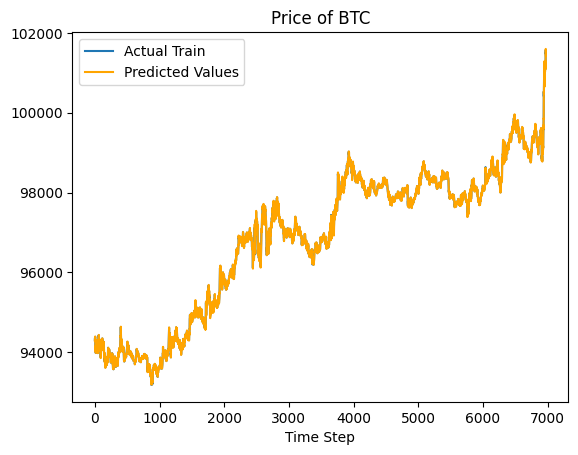

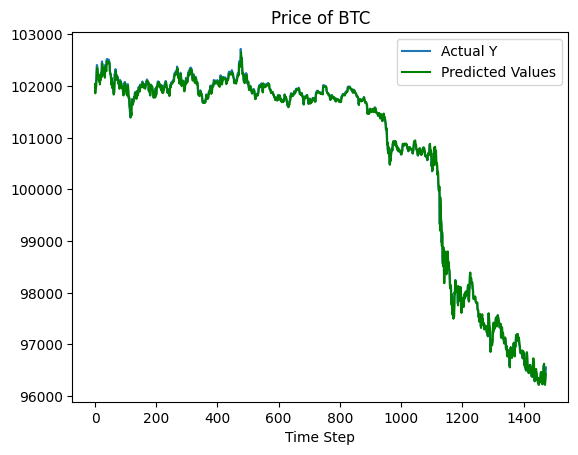

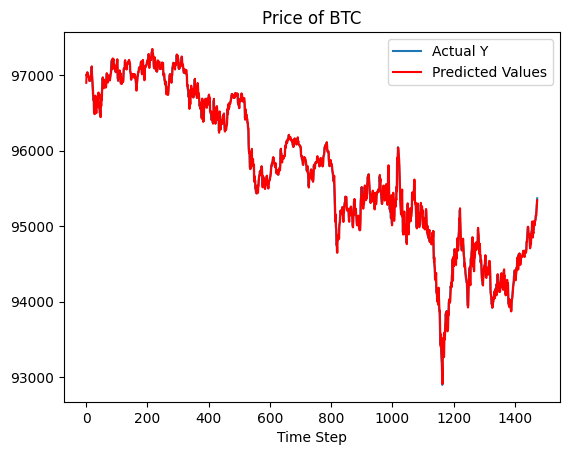

In [17]:

plt.plot(original_y_train, label="Actual Train")
plt.plot(original_train_pred, c='orange', label="Predicted Values")
plt.xlabel('Time Step')
plt.title('Price of BTC')
plt.legend()
plt.savefig("graphs/lstm-train-results.png")
plt.show()


plt.plot(original_y_valid, label="Actual Y")
plt.plot(original_valid_pred, c='green', label="Predicted Values")
plt.xlabel('Time Step')
plt.title('Price of BTC')
plt.legend()
plt.savefig("graphs/lstm-valid-results.png")
plt.show()


plt.plot(original_y_test, label="Actual Y")
plt.plot(original_test_pred, c='red', label="Predicted Values")
plt.xlabel('Time Step')
plt.title('Price of BTC')
plt.legend()
plt.savefig("graphs/lstm-test-results.png")
plt.show()